In [1]:
import os
import pandas as pd

Describe and argue:
    
    – The choice of the architectures, the layer types, the layer sizes and the activations.
    
    – The choice of the different hyper-parameters: batch size, learning rate, number of epochs, regularization weight...
    
    – The choice of the loss function.
    
    – Comparethetime taken by the different models, their memory footprint and their accuracy. What conclusions do you draw?

RNN (Réseau de Neurones Récurrents) : Les RNN sont un choix naturel pour les données séquentielles comme le texte, car ils traitent les entrées un élément à la fois et maintiennent un état caché qui capture des informations provenant des étapes précédentes de la séquence. Cependant, les RNN sont sujets aux problèmes de gradients disparus ou explosés, ce qui les rend plus difficiles à entraîner sur des séquences longues.

LSTM (Long Short-Term Memory) : Les LSTMs résolvent le problème des gradients disparus en introduisant des cellules mémoire qui peuvent stocker des informations sur de longues périodes. Cela rend les LSTMs particulièrement adaptés pour des tâches comme l'analyse de sentiment, où des dépendances à long terme (par exemple, le sentiment global d'une critique) sont cruciales.

GRU (Gated Recurrent Unit) : Les GRUs sont une variation des LSTMs avec une architecture plus simple (moins de portes). Ils ont souvent des performances similaires à celles des LSTMs mais sont moins coûteux en termes de calcul, ce qui en fait un bon choix pour un entraînement plus rapide.

MLP (Multilayer Perceptron) : Un MLP est un réseau de neurones entièrement connecté qui peut être utilisé pour toute tâche de prédiction, y compris l'analyse de sentiments. Il ne gère pas de manière inhérente les données séquentielles comme les RNNs ou LSTMs, mais en utilisant des techniques comme le bag-of-words ou des embeddings de mots, les MLPs peuvent quand même bien performer sur des tâches de classification de texte.

CNN (Convolutional Neural Network) : Bien que les CNNs soient traditionnellement utilisés pour la classification d'images, ils peuvent également être appliqués au texte en utilisant des convolutions 1D. Cette architecture peut capturer des motifs locaux dans le texte (par exemple, des n-grams) et a montré qu'elle fonctionne efficacement pour les tâches de classification de texte.

La couche de sortie utilise une activation sigmoid pour les tâches de classification binaire (sentiment positif ou négatif).

Fonction de perte : Entropie croisée binaire : Pour les tâches de classification binaire comme l'analyse de sentiment (positif ou négatif), la fonction de perte utilisée est généralement l'entropie croisée binaire (binary_crossentropy). Cette fonction calcule la perte log entre la probabilité prédite et la vraie étiquette.

## I. Importation des données

In [234]:
# Définir le chemin du dossier principal contenant les données
base_dir = 'IMDB_dataset'  # Remplacez par le chemin réel de votre dossier

# Initialiser les DataFrames vides pour les ensembles d'entraînement, de test et non étiquetés
train_df = pd.DataFrame(columns=["text", "label"])
test_df = pd.DataFrame(columns=["text", "label"])
unlabeled_data = pd.DataFrame(columns=["text"])

# Parcourir les dossiers train et test pour charger les fichiers étiquetés
for folder in ['train', 'test']:
    for sentiment in ['pos', 'neg']:
        # Créer le chemin complet pour chaque dossier (pos/neg)
        sentiment_folder = os.path.join(base_dir, folder, sentiment)
        
        # Initialiser une liste pour stocker les données de chaque dossier
        texts = []
        labels = []
        
        # Parcourir tous les fichiers .txt dans le dossier
        for filename in os.listdir(sentiment_folder):
            if filename.endswith('.txt'):
                # Créer le chemin complet du fichier
                file_path = os.path.join(sentiment_folder, filename)
                
                # Ouvrir le fichier et lire son contenu
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()  # Lire tout le contenu du fichier
                
                # Ajouter le texte et l'étiquette correspondante à la liste
                texts.append(text)
                labels.append(1 if sentiment == 'pos' else 0)  # 1 pour positif, 0 pour négatif
        
        # Créer un DataFrame pour le dossier actuel
        temp_df = pd.DataFrame({"text": texts, "label": labels})
        
        # Ajouter les données au DataFrame d'entraînement ou de test
        if folder == 'train':
            train_df = pd.concat([train_df, temp_df], ignore_index=True)
        elif folder == 'test':
            test_df = pd.concat([test_df, temp_df], ignore_index=True)

# Traiter les données non étiquetées dans le dossier 'train/unsup'
unsup_folder = os.path.join(base_dir, 'train', 'unsup')

# Initialiser une liste pour les textes non étiquetés
unlabeled_texts = []

# Parcourir tous les fichiers .txt dans le dossier unsup
for filename in os.listdir(unsup_folder):
    if filename.endswith('.txt'):
        # Créer le chemin complet du fichier
        file_path = os.path.join(unsup_folder, filename)
        
        # Ouvrir le fichier et lire son contenu
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()  # Lire tout le contenu du fichier
        
        # Ajouter le texte à la liste des données non étiquetées
        unlabeled_texts.append(text)

# Créer un DataFrame pour les données non étiquetées
unlabeled_data = pd.DataFrame({"text": unlabeled_texts})

KeyboardInterrupt: 

In [238]:
# Chargement des DataFrames depuis un fichier CSV
train_df = pd.read_csv("train_data.csv", encoding='utf-8')
test_df = pd.read_csv("test_data.csv", encoding='utf-8')
unlabeled_data = pd.read_csv("unlabeled_data.csv", encoding='utf-8')


## II. Prétraitement des données

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns


# Vérifier la taille des DataFrames et afficher le nombre de "pos" et "neg"
print(f"Nombre d'exemples dans le train set : {train_df.shape[0]}")  # Nombre d'exemples d'entraînement
print(f"Nombre d'exemples dans le test set : {test_df.shape[0]}")    # Nombre d'exemples de test
print(f"Nombre d'exemples non étiquetés dans le train/unsup : {unlabeled_data.shape[0]}")  # Nombre de données non étiquetées

Nombre d'exemples dans le train set : 25000
Nombre d'exemples dans le test set : 25000
Nombre d'exemples non étiquetés dans le train/unsup : 50000


In [240]:
train_df.head()

,text,label
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [241]:
unlabeled_data.head()

,text
0,"I admit, the great majority of films released ..."
1,"Take a low budget, inexperienced actors doubli..."
2,"Everybody has seen 'Back To The Future,' right..."
3,Doris Day was an icon of beauty in singing and...
4,"After a series of silly, fun-loving movies, 19..."


In [242]:
# Vérification des valeurs nulles
print("\nVérification des valeurs nulles dans le train set :")
print(train_df.isnull().sum())  # Compte les valeurs nulles dans chaque colonne

print("\nVérification des valeurs nulles dans le test set :")
print(test_df.isnull().sum())  # Compte les valeurs nulles dans chaque colonne

print("\nVérification des valeurs nulles dans les données non étiquetées :")
print(unlabeled_data.isnull().sum())  # Compte les valeurs nulles dans chaque colonne


Vérification des valeurs nulles dans le train set :
text     0
label    0
dtype: int64

Vérification des valeurs nulles dans le test set :
text     0
label    0
dtype: int64

Vérification des valeurs nulles dans les données non étiquetées :
text    0
dtype: int64


In [243]:
# Vérification des doublons
print("\nVérification des doublons dans le train set :")
print(train_df.duplicated().sum())  # Nombre de lignes dupliquées dans le train set

print("\nVérification des doublons dans le test set :")
print(test_df.duplicated().sum())  # Nombre de lignes dupliquées dans le test set

print("\nVérification des doublons dans les données non étiquetées :")
print(unlabeled_data.duplicated().sum())  # Nombre de lignes dupliquées dans les données non étiquetées

# Extraire les textes de l'ensemble train et test
train_texts = train_df["text"]
test_texts = test_df["text"]

# Trouver l'intersection entre les deux ensembles de textes (train et test)
common_texts = set(train_texts).intersection(set(test_texts))

# Afficher le nombre d'éléments communs (intersection)
print(f"\nNombre de commentaires communs entre l'ensemble train et l'ensemble test : {len(common_texts)}")


Vérification des doublons dans le train set :
96

Vérification des doublons dans le test set :
199

Vérification des doublons dans les données non étiquetées :
493

Nombre de commentaires communs entre l'ensemble train et l'ensemble test : 123


In [244]:
# Supprimer les doublons dans train et test
train_df = train_df.drop_duplicates(subset=["text"])
test_df = test_df.drop_duplicates(subset=["text"])
unlabeled_data = unlabeled_data.drop_duplicates(subset=["text"])

# Trouver l'intersection
common_texts = set(train_df["text"]).intersection(set(test_df["text"]))

# Supprimer les commentaires communs dans les deux ensembles
test_df = test_df[~test_df["text"].isin(common_texts)]

# Afficher les tailles après nettoyage
print(f"Train set size after cleaning: {train_df.shape[0]}")
print(f"Test set size after cleaning: {test_df.shape[0]}")

Train set size after cleaning: 24904
Test set size after cleaning: 24678


In [245]:
train_df['label'] = train_df['label'].astype('category')
test_df['label'] = test_df['label'].astype('category')

In [246]:
from sklearn.model_selection import train_test_split

# Diviser les données d'entraînement en train et validation
train_df,val_df = train_test_split(train_df, test_size=0.15, random_state=42)


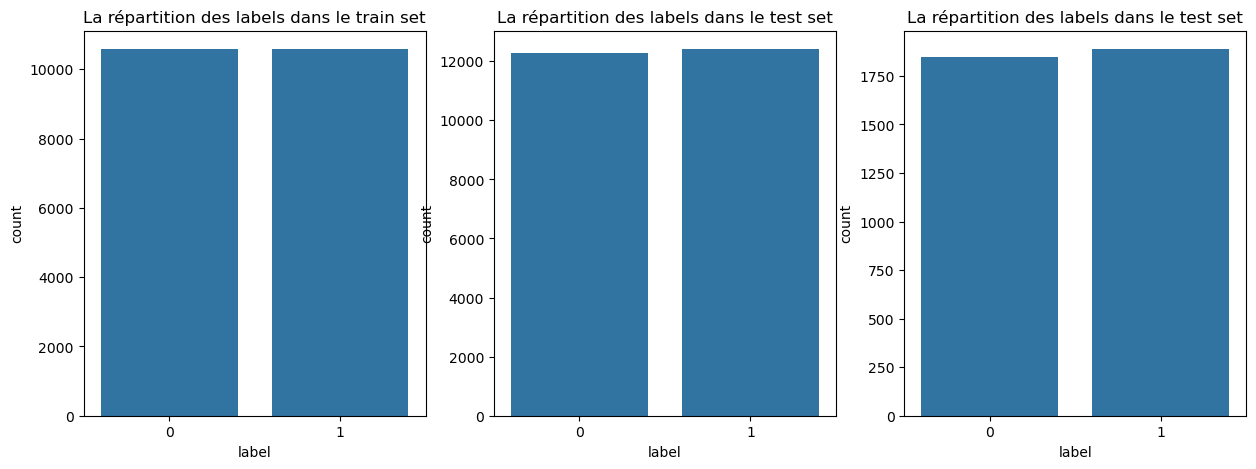

In [247]:
# Afficher le nombre de 'pos' et 'neg' dans les train et test sets

plt.figure(figsize=(15,5))
plt.subplot(131)
sns.countplot(x=train_df["label"])# Affiche la répartition des labels dans le train set
plt.title("La répartition des labels dans le train set")

plt.subplot(132)
sns.countplot(x=test_df["label"])# Affiche la répartition des labels dans le train set
plt.title("La répartition des labels dans le test set")


plt.subplot(133)
sns.countplot(x=val_df["label"])# Affiche la répartition des labels dans le train set
plt.title("La répartition des labels dans le test set")
plt.show()



### Tokenisation

In [248]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns

# 1. Appliquer TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Limit to 1000 features
train_tfidf = vectorizer.fit_transform(train_df["text"])
val_tfidf=vectorizer.transform(val_df["text"])
test_tfidf = vectorizer.transform(test_df["text"])



### Essaie Logistic regression

In [249]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(train_tfidf, train_df['label'])

train_score = model.score(train_tfidf,train_df['label'] )
print(train_score)

0.8713151927437641


Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12266
           1       0.85      0.87      0.86     12412

    accuracy                           0.85     24678
   macro avg       0.85      0.85      0.85     24678
weighted avg       0.85      0.85      0.85     24678

Confusion Matrix:


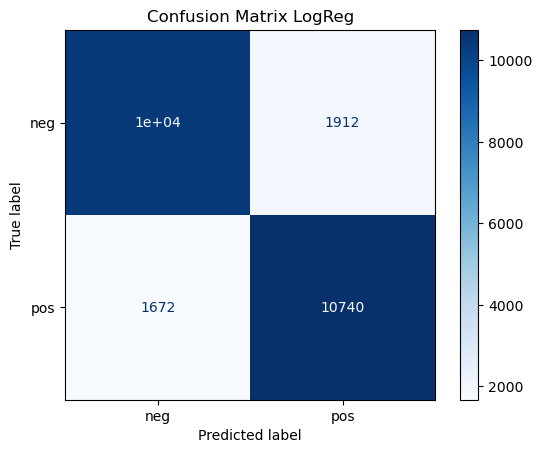

In [251]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur les données de test
y_pred = model.predict(test_tfidf)

# Calcul de l'accuracy
accuracy = accuracy_score(test_df["label"], y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Rapport de classification
print("Classification Report:")
print(classification_report(test_df["label"], y_pred))

# Matrice de confusion
print("Confusion Matrix:")
cm = confusion_matrix(test_df["label"], y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix LogReg")
plt.show()

## III. Modélisation

### III.1 RNN

In [252]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout,LSTM,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
# 1. Tokenisation des données
# Puisque nous avons des données TF-IDF, nous allons les utiliser directement, sans passage par l'Embedding traditionnel
# Nous devons simplement gérer la forme des données pour les utiliser dans le modèle RNN.

# Convertir les données TF-IDF en tableau dense pour que le RNN puisse les prendre en entrée
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()


y_train=train_df['label'].to_numpy()
y_val=val_df['label'].to_numpy()

In [253]:
# 2. Construction du modèle RNN
model_rnn = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
#model_rnn.add(SimpleRNN(128, activation='tanh'))  # Première couche RNN, return_sequences=True permet de passer les séquences à la couche suivante

model_rnn.add(SimpleRNN(128, activation='tanh', input_shape=(1, train_tfidf_dense.shape[1])))


# Dropout pour éviter le surapprentissage
model_rnn.add(Dropout(0.5))

# Couche de sortie pour la classification binaire
model_rnn.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_rnn.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_rnn.summary()

C:\Users\X415\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_25 (SimpleRNN)            │ (None, 128)                 │         144,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,641 (565.00 KB)

 Trainable params: 144,641 (565.00 KB)

 Non-trainable params: 0 (0.00 B)

In [254]:
# 4. Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))




start_time= time.time()
# 5. Entraînement du modèle
history=model_rnn.fit(train_tfidf_dense, y_train,
          epochs=50, 
          batch_size=32, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_RNN=end_time - start_time

Epoch 1/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5967 - loss: 0.6830 - val_accuracy: 0.7631 - val_loss: 0.6588
Epoch 2/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7556 - loss: 0.6490 - val_accuracy: 0.8073 - val_loss: 0.6246
Epoch 3/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8006 - loss: 0.6124 - val_accuracy: 0.8239 - val_loss: 0.5871
Epoch 4/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8200 - loss: 0.5731 - val_accuracy: 0.8303 - val_loss: 0.5490
Epoch 5/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8313 - loss: 0.5332 - val_accuracy: 0.8298 - val_loss: 0.5134
Epoch 6/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8337 - loss: 0.4971 - val_accuracy: 0.8338 - val_loss: 0.4821
Epoch 7/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8397 - loss: 0.4654 - val_accuracy: 0.8367 - val_loss: 0.4556
Epoch 8/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8466 - loss: 0.4351 - val_accuracy: 0.

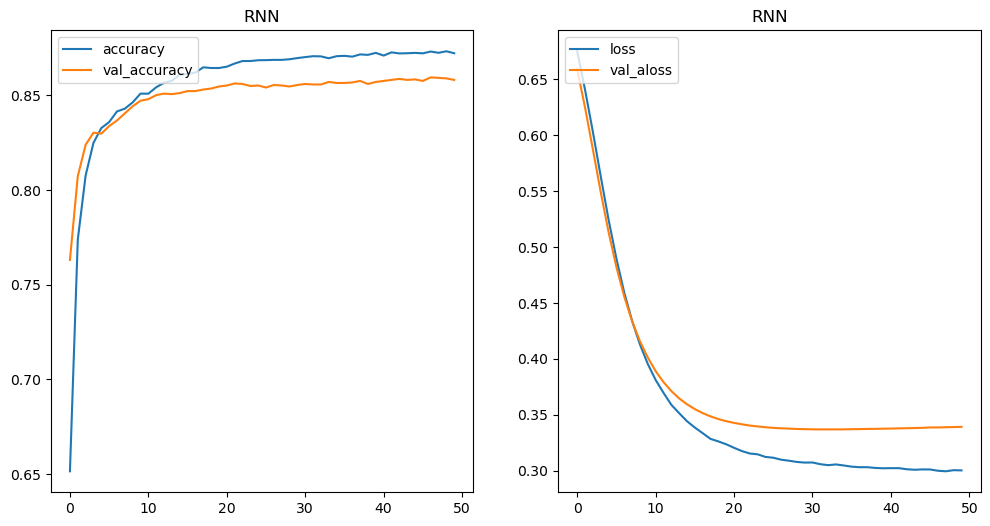

In [255]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("RNN")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("RNN")
plt.legend(loc='upper left')
plt.show()

In [258]:
# Reshape test data to 3D (batch_size, timesteps, features)
##test_tfidf_reshaped = np.expand_dims(test_tfidf.toarray(), axis=-1)
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))
# Evaluate the model
loss_rnn, accuracy_rnn = model_rnn.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Display results
print(f"Test Loss: {loss_rnn:.4f}, Test Accuracy: {accuracy_rnn:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8632 - loss: 0.3188
Test Loss: 0.3275, Test Accuracy: 0.8555


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12266
           1       0.85      0.86      0.86     12412

    accuracy                           0.86     24678
   macro avg       0.86      0.86      0.86     24678
weighted avg       0.86      0.86      0.86     24678



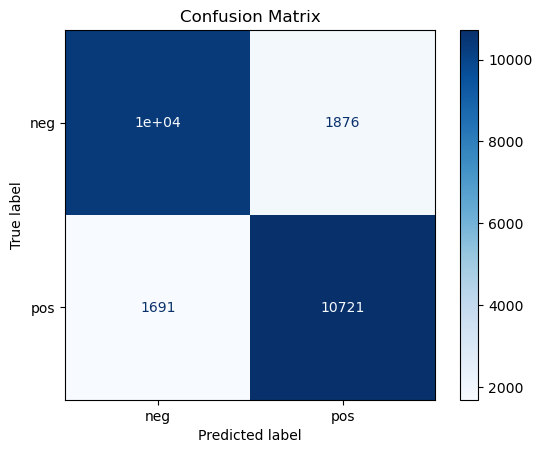

In [257]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_rnn.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [259]:
duration={}
accuracy={}

In [260]:
duration["RNN"] = time_RNN
accuracy["RNN"] = accuracy_rnn

In [261]:
duration,accuracy

({'RNN': 117.91158103942871}, {'RNN': 0.8554583191871643})

### III.2 LSTM

In [262]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [263]:
# 2. Construction du modèle RNN
model_lstm = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
model_lstm.add(LSTM(128, activation='tanh',input_shape=(1, train_tfidf_dense.shape[1])))  # Première couche LSTM, return_sequences=True permet de passer les séquences à la couche suivante



# Dropout pour éviter le surapprentissage
model_lstm.add(Dropout(0.5))

# Couche de sortie pour la classification binaire
model_lstm.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_lstm.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])


model_lstm.summary()

C:\Users\X415\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 128)                 │         578,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 578,177 (2.21 MB)

 Trainable params: 578,177 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [264]:
# 4. Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

start_time= time.time()
# 5. Entraînement du modèle
history=model_lstm.fit(train_tfidf_dense, y_train,
          epochs=50, 
          batch_size=32, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_LSTM=end_time - start_time

Epoch 1/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6031 - loss: 0.6904 - val_accuracy: 0.7722 - val_loss: 0.6838
Epoch 2/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7727 - loss: 0.6803 - val_accuracy: 0.8051 - val_loss: 0.6719
Epoch 3/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8078 - loss: 0.6662 - val_accuracy: 0.8129 - val_loss: 0.6548
Epoch 4/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8148 - loss: 0.6471 - val_accuracy: 0.8164 - val_loss: 0.6317
Epoch 5/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8325 - loss: 0.6199 - val_accuracy: 0.8223 - val_loss: 0.6036
Epoch 6/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8261 - loss: 0.5917 - val_accuracy: 0.8247 - val_loss: 0.5725
Epoch 7/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8334 - loss: 0.5568 - val_accuracy: 0.8290 - val_loss: 0.5406
Epoch 8/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8361 - loss: 0.5247 - val_accuracy

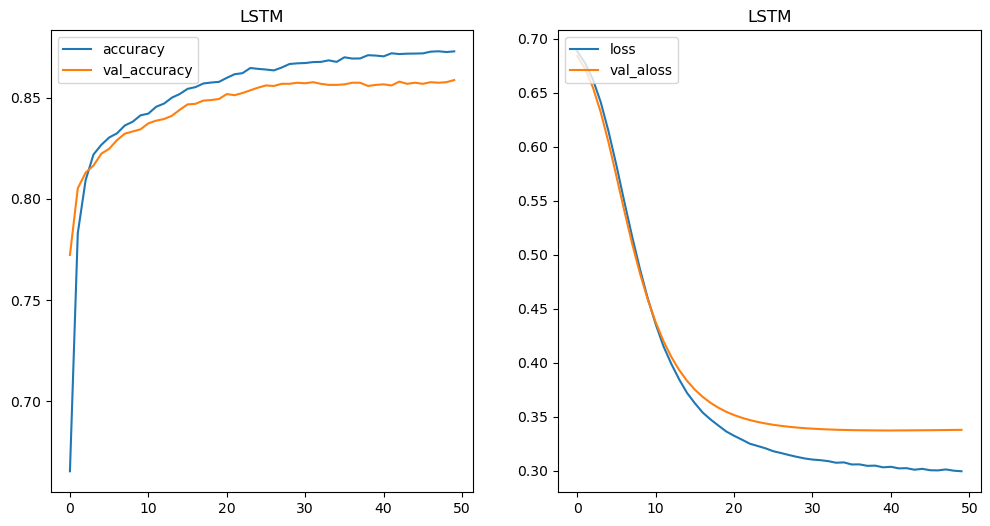

In [265]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("LSTM")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("LSTM")
plt.legend(loc='upper left')
plt.show()

In [266]:
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))

# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_LSTM, accuracy_LSTM = model_lstm.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_LSTM:.4f}, Test Accuracy: {accuracy_LSTM:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8648 - loss: 0.3163
Test Loss: 0.3251, Test Accuracy: 0.8565


In [267]:
duration["LSTM"] = time_LSTM
accuracy["LSTM"] = accuracy_LSTM

In [166]:
duration, accuracy

({'RNN': 95.25153136253357, 'LSTM': 222.25452637672424},
 {'RNN': 0.8554988503456116, 'LSTM': 0.8556609153747559})

772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12266
           1       0.85      0.87      0.86     12412

    accuracy                           0.86     24678
   macro avg       0.86      0.86      0.86     24678
weighted avg       0.86      0.86      0.86     24678



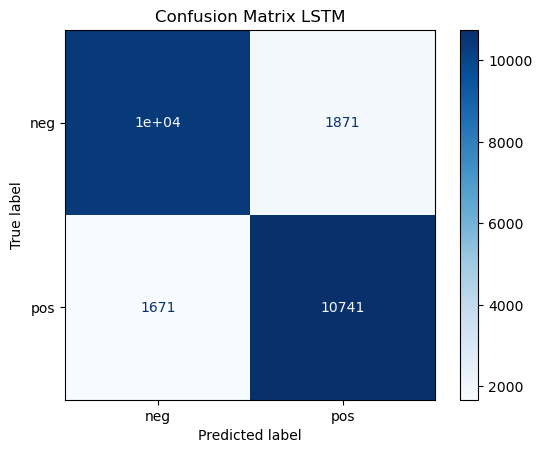

In [268]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_lstm.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix LSTM")
plt.show()

### III.3 GRU

In [269]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [270]:
# 2. Construction du modèle RNN
model_gru = Sequential()

# Ajouter une couche SimpleRNN avec 64 unités
model_gru.add(GRU(128, activation='tanh',input_shape=(1, train_tfidf_dense.shape[1])))  # Première couche LSTM, return_sequences=True permet de passer les séquences à la couche suivante



# Dropout pour éviter le surapprentissage
model_gru.add(Dropout(0.5))

# Couche de sortie pour la classification binaire
model_gru.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_gru.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])


model_gru.summary()

C:\Users\X415\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 128)                 │         433,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 434,049 (1.66 MB)

 Trainable params: 434,049 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [271]:
# 4. Reshaper les données d'entrée
train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

start_time= time.time()
# 5. Entraînement du modèle
history=model_gru.fit(train_tfidf_dense, y_train,
          epochs=50, 
          batch_size=32, 
          validation_data=(val_tfidf_dense, y_val), 
          verbose=1)

end_time=time.time()

time_GRU=end_time - start_time

Epoch 1/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5616 - loss: 0.6898 - val_accuracy: 0.7687 - val_loss: 0.6761
Epoch 2/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7645 - loss: 0.6699 - val_accuracy: 0.8089 - val_loss: 0.6543
Epoch 3/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8105 - loss: 0.6454 - val_accuracy: 0.8241 - val_loss: 0.6264
Epoch 4/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8256 - loss: 0.6136 - val_accuracy: 0.8249 - val_loss: 0.5930
Epoch 5/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8315 - loss: 0.5794 - val_accuracy: 0.8266 - val_loss: 0.5575
Epoch 6/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8293 - loss: 0.5427 - val_accuracy: 0.8284 - val_loss: 0.5228
Epoch 7/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8358 - loss: 0.5078 - val_accuracy: 0.8314 - val_loss: 0.4915
Epoch 8/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8433 - loss: 0.4751 - val_accuracy: 0.

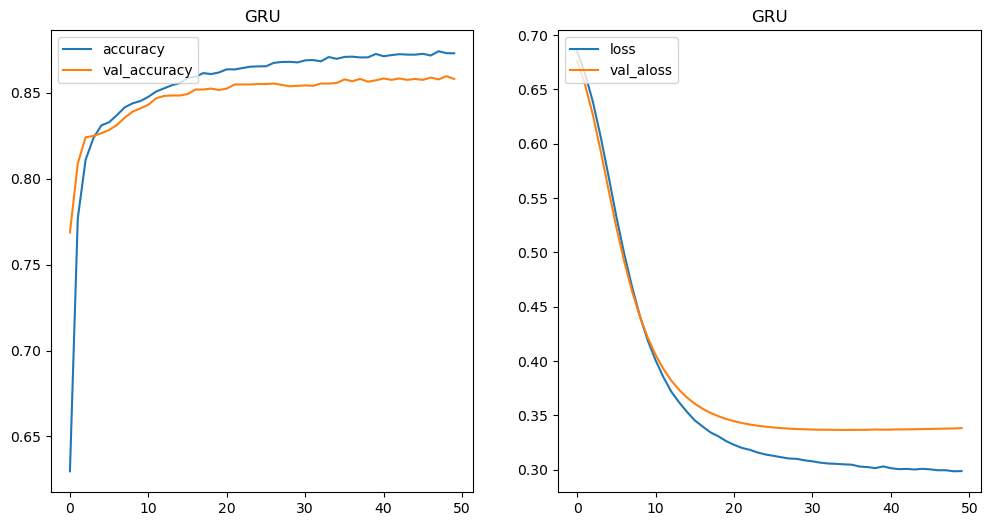

In [272]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("GRU")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_aloss')
plt.title("GRU")
plt.legend(loc='upper left')
plt.show()

In [273]:
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))

# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_GRU, accuracy_GRU = model_gru.evaluate(test_tfidf_dense, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_GRU:.4f}, Test Accuracy: {accuracy_GRU:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8605 - loss: 0.3235
Test Loss: 0.3264, Test Accuracy: 0.8556


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     12266
           1       0.85      0.86      0.86     12412

    accuracy                           0.86     24678
   macro avg       0.86      0.86      0.86     24678
weighted avg       0.86      0.86      0.86     24678



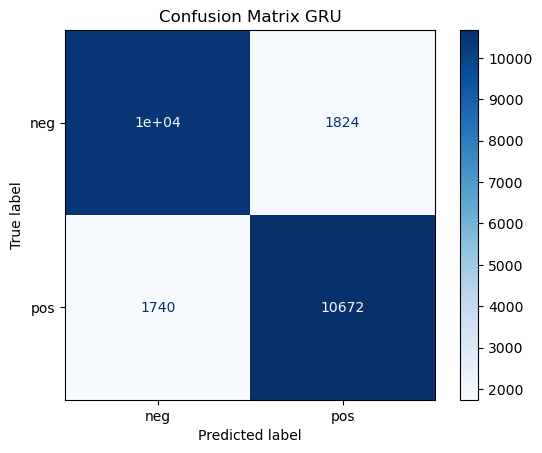

In [274]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_gru.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix GRU")
plt.show()

In [275]:
duration["GRU"] = time_GRU
accuracy["GRU"] = accuracy_GRU

### III.4 MLP

In [276]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [277]:
# 2. Construction du modèle MLP
model_mlp = Sequential()

# Ajouter une couche d'entrée entièrement connectée avec 128 unités
model_mlp.add(Dense(64, activation='relu', input_dim=train_tfidf.shape[1]))  # Entrée dense, avec ReLU

# Dropout pour éviter le surapprentissage
model_mlp.add(Dropout(0.5))

# Ajouter une autre couche cachée entièrement connectée avec 64 unités
model_mlp.add(Dense(128, activation='relu'))

# Couche de sortie pour la classification binaire
model_mlp.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_mlp.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

model_mlp.summary()

C:\Users\X415\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                     │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,513 (283.25 KB)

 Trainable params: 72,513 (283.25 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
# train_tfidf_dense = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], 1, train_tfidf_dense.shape[1]))
# val_tfidf_dense = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], 1, val_tfidf_dense.shape[1]))

# 4. Entraînement du modèle MLP
start_time_mlp = time.time()

history_mlp = model_mlp.fit(train_tfidf, y_train,
                            epochs=50, 
                            batch_size=32, 
                            validation_data=(val_tfidf, y_val), 
                            verbose=1)

end_time_mlp = time.time()

# Durée de l'entraînement
time_mlp = end_time_mlp - start_time_mlp


Epoch 1/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5229 - loss: 0.6922 - val_accuracy: 0.6325 - val_loss: 0.6873
Epoch 2/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6303 - loss: 0.6841 - val_accuracy: 0.7369 - val_loss: 0.6661
Epoch 3/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7249 - loss: 0.6567 - val_accuracy: 0.8011 - val_loss: 0.6024
Epoch 4/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7824 - loss: 0.5864 - val_accuracy: 0.8225 - val_loss: 0.5087
Epoch 5/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7967 - loss: 0.5051 - val_accuracy: 0.8370 - val_loss: 0.4396
Epoch 6/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8160 - loss: 0.4443 - val_accuracy: 0.8413 - val_loss: 0.4003
Epoch 7/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8270 - loss: 0.4054 - val_accuracy: 0.8461 - val_loss: 0.3782
Epoch 8/50
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8268 - loss: 0.3949 - val_accuracy: 0.

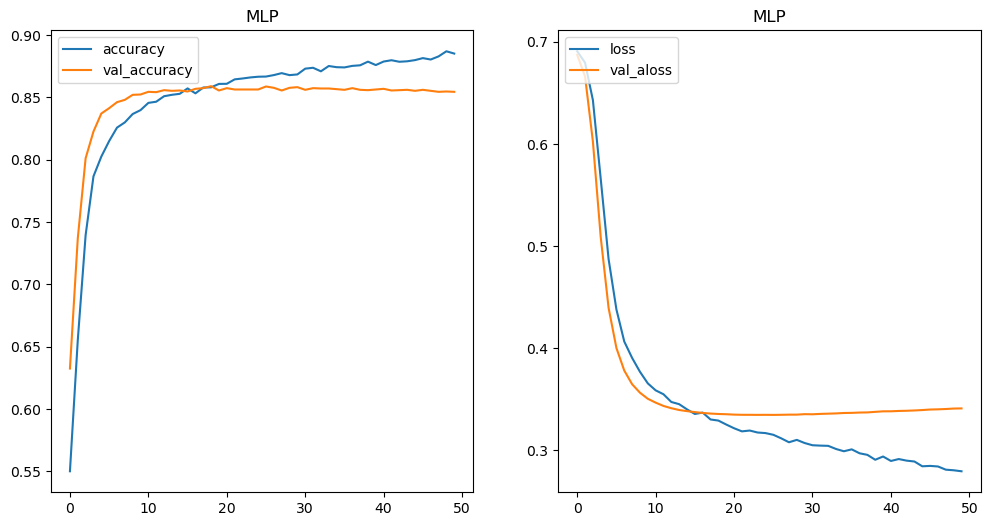

In [279]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_mlp.history['accuracy'], label='accuracy')
plt.plot(history_mlp.history['val_accuracy'], label = 'val_accuracy')
plt.title("MLP")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history_mlp.history['loss'], label='loss')
plt.plot(history_mlp.history['val_loss'], label = 'val_aloss')
plt.title("MLP")
plt.legend(loc='upper left')
plt.show()

In [280]:


# Maintenant vous pouvez appeler le modèle avec les données correctement redimensionnées
loss_MLP, accuracy_MLP = model_mlp.evaluate(test_tfidf, test_df['label'].to_numpy(), verbose=1)

# Afficher les résultats
print(f"Test Loss: {loss_MLP:.4f}, Test Accuracy: {accuracy_MLP:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8641 - loss: 0.3188
Test Loss: 0.3326, Test Accuracy: 0.8538


772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12266
           1       0.85      0.87      0.86     12412

    accuracy                           0.85     24678
   macro avg       0.85      0.85      0.85     24678
weighted avg       0.85      0.85      0.85     24678



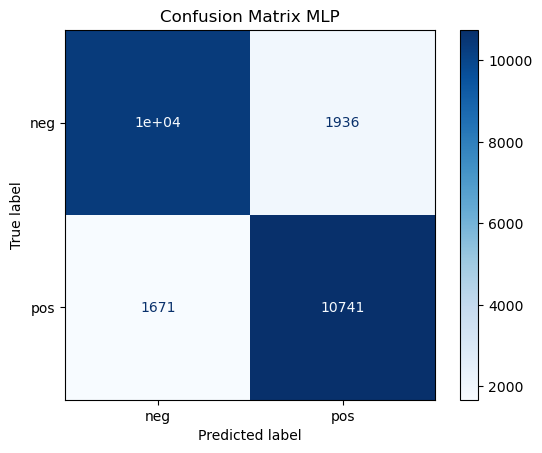

In [281]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_mlp.predict(test_tfidf)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix MLP")
plt.show()

In [282]:
duration["MLP"] = time_mlp
accuracy["MLP"] = accuracy_MLP

### III.5 Conv1D

In [283]:
train_tfidf_dense = train_tfidf.toarray()  # Passer de sparse à dense
val_tfidf_dense = val_tfidf.toarray()

In [284]:

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
# 2. Construction du modèle Conv1D
model_conv1d = Sequential()

# Ajouter une couche de convolution 1D
model_conv1d.add(Conv1D(128, 5, activation='relu', input_shape=(train_tfidf_dense.shape[1], 1)))  # 128 filtres, taille de noyau = 5

# Ajouter une couche de pooling pour réduire les dimensions
model_conv1d.add(MaxPooling1D(pool_size=2))  # Pooling avec une taille de 2

# Applatissement de la sortie pour la connecter à des couches denses
model_conv1d.add(Flatten())

# Dropout pour éviter le surapprentissage
model_conv1d.add(Dropout(0.5))

# Ajouter une couche entièrement connectée
model_conv1d.add(Dense(64, activation='relu'))

# Couche de sortie pour la classification binaire
model_conv1d.add(Dense(1, activation='sigmoid'))  # 'sigmoid' pour une classification binaire

# 3. Compilation du modèle
model_conv1d.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_conv1d.summary()


C:\Users\X415\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 996, 128)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 498, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 63744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 63744)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 64)                  │       4,079,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,080,513 (15.57 MB)

 Trainable params: 4,080,513 (15.57 MB)

 Non-trainable params: 0 (0.00 B)

In [285]:
# Reshape train and validation data for Conv1D
train_tfidf_dense_reshaped = train_tfidf_dense.reshape((train_tfidf_dense.shape[0], train_tfidf_dense.shape[1], 1))  # Adding the third dimension (1 feature per word)
val_tfidf_dense_reshaped = val_tfidf_dense.reshape((val_tfidf_dense.shape[0], val_tfidf_dense.shape[1], 1))

# Start training the model
start_time_conv1d = time.time()

history_conv1d = model_conv1d.fit(train_tfidf_dense_reshaped, y_train,
                                  epochs=10, 
                                  batch_size=32, 
                                  validation_data=(val_tfidf_dense_reshaped, y_val), 
                                  verbose=1)

end_time_conv1d = time.time()

# Store the training time for Conv1D
time_conv1d = end_time_conv1d - start_time_conv1d


Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 135s 201ms/step - accuracy: 0.7256 - loss: 0.6539 - val_accuracy: 0.7955 - val_loss: 0.5351
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.8029 - loss: 0.5001 - val_accuracy: 0.8108 - val_loss: 0.4501
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 68s 103ms/step - accuracy: 0.8240 - loss: 0.4219 - val_accuracy: 0.8249 - val_loss: 0.4143
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.8279 - loss: 0.3951 - val_accuracy: 0.8225 - val_loss: 0.4002
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 65s 99ms/step - accuracy: 0.8360 - loss: 0.3708 - val_accuracy: 0.8300 - val_loss: 0.3874
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.8428 - loss: 0.3638 - val_accuracy: 0.8349 - val_loss: 0.3782
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.8444 - loss: 0.3541 - val_accuracy: 0.8359 - val_loss: 0.3768
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - accuracy: 0.8500 - loss: 0.3

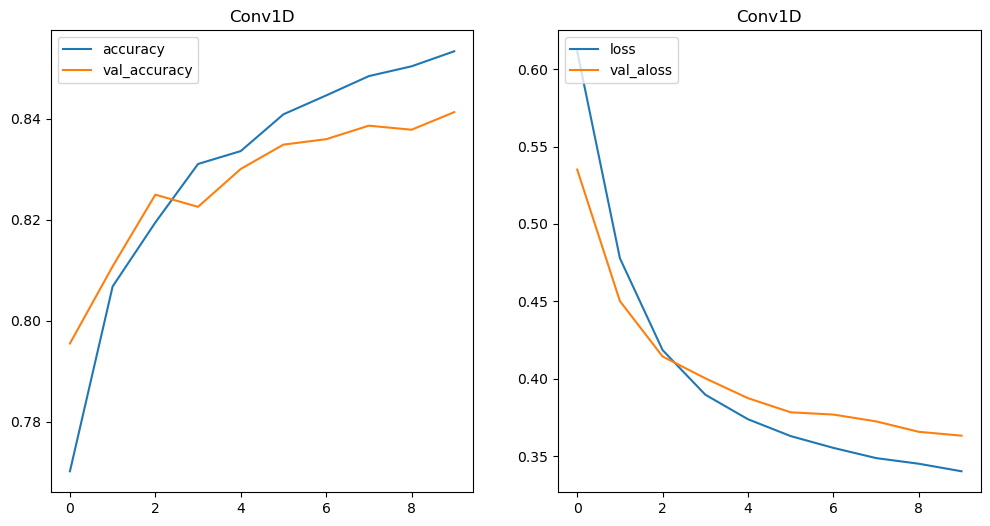

In [291]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(history_conv1d.history['accuracy'], label='accuracy')
plt.plot(history_conv1d.history['val_accuracy'], label = 'val_accuracy')
plt.title("Conv1D")
plt.legend(loc='upper left')

plt.subplot(122)
plt.plot(history_conv1d.history['loss'], label='loss')
plt.plot(history_conv1d.history['val_loss'], label = 'val_aloss')
plt.title("Conv1D")
plt.legend(loc='upper left')
plt.show()

In [287]:
# Reshape test data for Conv1D (3D)
test_tfidf_dense = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], test_tfidf.toarray().shape[1], 1))

# Convert labels to numpy array (if they are in pandas DataFrame)
y_test = test_df['label'].to_numpy()

# Now you can evaluate the model with the correctly shaped data
loss_conv1d, accuracy_conv1d = model_conv1d.evaluate(test_tfidf_dense, y_test, verbose=1)

# Display the results
print(f"Test Loss: {loss_conv1d:.4f}, Test Accuracy: {accuracy_conv1d:.4f}")


772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8552 - loss: 0.3367
Test Loss: 0.3496, Test Accuracy: 0.8442


772/772 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     12266
           1       0.84      0.86      0.85     12412

    accuracy                           0.84     24678
   macro avg       0.84      0.84      0.84     24678
weighted avg       0.84      0.84      0.84     24678



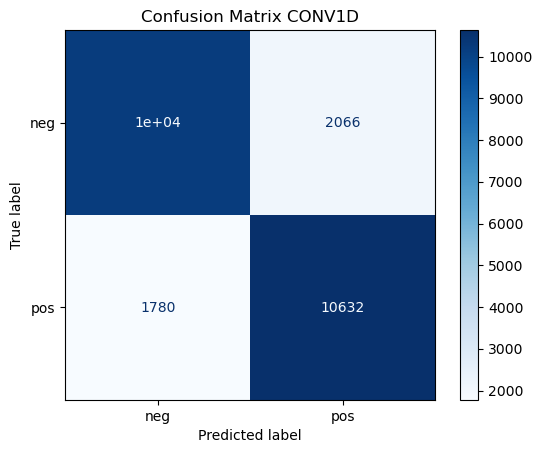

In [288]:
# Make predictions (use model to predict on the reshaped test data)
y_pred = model_conv1d.predict(test_tfidf_dense)

# Since we are dealing with a binary classification problem, we need to convert predictions to binary (0 or 1)
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(test_df['label'], y_pred_bin))


# Confusion matrix
cm = confusion_matrix(test_df['label'], y_pred_bin)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix CONV1D")
plt.show()

In [289]:
duration["CONV1D"] = time_conv1d
accuracy["CONV1D"] = accuracy_conv1d

## IV Comparaison 


Text(0.5, 1.0, 'Accuracy par modele')

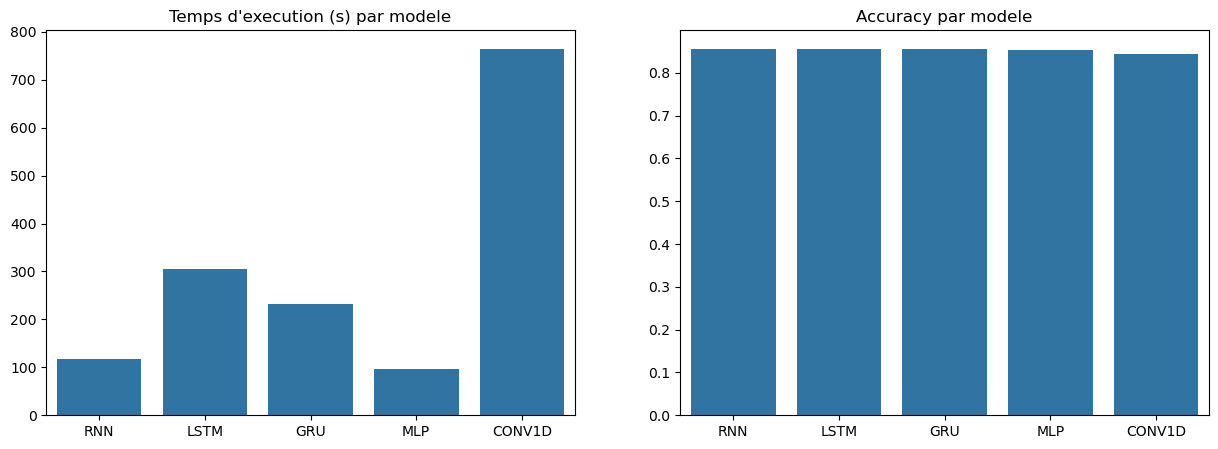

In [290]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(duration)
plt.title("Temps d'execution (s) par modele")
plt.subplot(122)
sns.barplot(accuracy)
plt.title("Accuracy par modele")

## V. Assemblage des modeles

772/772 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step
772/772 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


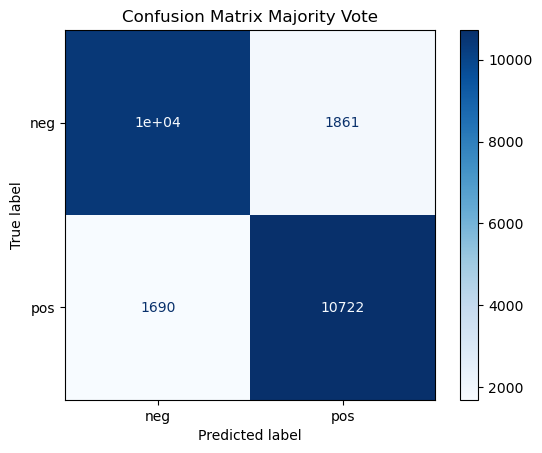

In [294]:
from sklearn.metrics import accuracy_score

# Assuming `model_rnn`, `model_lstm`, `model_gru`, `model_conv1d`, and `model_mlp`
# have been trained and the corresponding test data is available
test_tfidf_densegru = test_tfidf.toarray().reshape((test_tfidf.toarray().shape[0], 1, test_tfidf.toarray().shape[1]))
# Step 1: Make predictions for each model
y_pred_rnn = (model_rnn.predict(test_tfidf_densegru) > 0.5).astype(int)
y_pred_lstm = (model_lstm.predict(test_tfidf_densegru) > 0.5).astype(int)
y_pred_gru = (model_gru.predict(test_tfidf_densegru) > 0.5).astype(int)
y_pred_conv1d = (model_conv1d.predict(test_tfidf_dense) > 0.5).astype(int)
y_pred_mlp = (model_mlp.predict(test_tfidf) > 0.5).astype(int)

# Step 2: Stack predictions from all models
predictions_stack = np.stack([y_pred_rnn, y_pred_lstm, y_pred_gru, y_pred_conv1d, y_pred_mlp], axis=0)

# Step 3: Apply majority voting (mode of the predictions)
# Each row corresponds to one test sample, and the majority vote is calculated across the models
ensemble_predictions = np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_stack))

# Step 4: Evaluate the ensemble
accuracy_ensemble = accuracy_score(test_df['label'], ensemble_predictions)
# Confusion matrix
cm = confusion_matrix(test_df['label'], ensemble_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Majority Vote")
plt.show()


<Axes: >

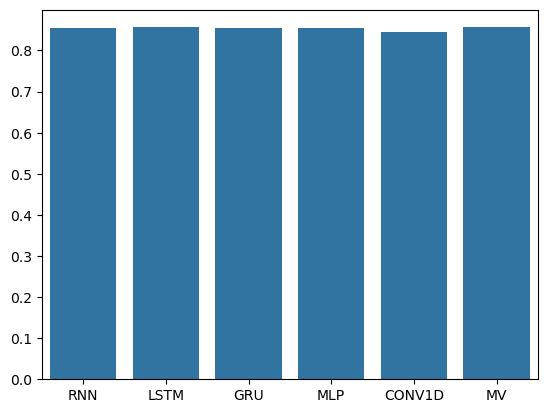

In [295]:
accuracy["MV"] = accuracy_ensemble
sns.barplot(accuracy)

In [300]:
val_df.duplicated().sum()

0

In [5]:
# Sauvegarde des DataFrames en CSV
train_df.to_csv("train_data.csv", index=False, encoding='utf-8')
test_df.to_csv("test_data.csv", index=False, encoding='utf-8')
unlabeled_data.to_csv("unlabeled_data.csv", index=False, encoding='utf-8')


In [237]:
train_df.shape

(25000, 2)

In [301]:
# Create a directory to save the models if it doesn't exist
import os
os.makedirs("saved_models", exist_ok=True)

# Save each model
model_rnn.save("saved_models/model_rnn.h5")
model_lstm.save("saved_models/model_lstm.h5")
model_gru.save("saved_models/model_gru.h5")
model_mlp.save("saved_models/model_mlp.h5")
model_conv1d.save("saved_models/model_conv1d.h5")

print("All models have been saved successfully!")


All models have been saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load each model
model_rnn = load_model("saved_models/model_rnn.h5")
model_lstm = load_model("saved_models/model_lstm.h5")
model_gru = load_model("saved_models/model_gru.h5")
model_mlp = load_model("saved_models/model_mlp.h5")
model_conv1d = load_model("saved_models/model_conv1d.h5")

print("All models have been loaded successfully!")
